In [1]:
# SPARQL query to pull work data and media from wiki via linked ids.

from IPython.display import Image, display
import json
import pandas
import pathlib
import pydash
import requests

def value_extract(row, column):

    ''' Extract dictionary values. '''
    
    return pydash.get(row[column], 'value')

def sparql_query(query, service):

    ''' Send sparql request, and formulate results into a dataframe. '''

    response = requests.get(service, params={'format': 'json', 'query': query}, timeout=120)
    results = pydash.get(response.json(), 'results.bindings')
    data_frame = pandas.DataFrame.from_dict(results)
    for column in data_frame.columns:
        data_frame[column] = data_frame.apply(value_extract, column=column, axis=1)
    
    return data_frame

acmi_work_id = '79859' # ACMI ID for Story Of The Kelly Gang.

query = '''
    select ?acmi_work ?wikidata_work ?wikidata_workLabel ?countryLabel ?date ?dod ?podLabel ?article ?image ?imageLicense  
    where {
        values ?acmi_work {"works/'''+acmi_work_id+'''"}
        ?wikidata_work wdt:P7003 ?acmi_work.
        optional { ?wikidata_work wdt:P495 ?country } .
        optional { ?wikidata_work wdt:P577 ?date } .
        optional { ?wikidata_work wdt:P18 ?image .
            bind(strafter(wikibase:decodeUri(str(?image)), "http://commons.wikimedia.org/wiki/Special:FilePath/") AS ?fileTitle)
            service wikibase:mwapi {
                bd:serviceParam wikibase:endpoint "commons.wikimedia.org";
                wikibase:api "Generator";
                wikibase:limit "once";
                mwapi:generator "allpages";
                mwapi:gapfrom ?fileTitle;
                mwapi:gapnamespace 6; # NS_FILE
                mwapi:gaplimit 1;
                mwapi:prop "imageinfo";
                mwapi:iiprop "extmetadata" .
                ?imageLicense wikibase:apiOutput "imageinfo/ii/extmetadata/License/@value".
            }
        }
        optional { ?article schema:about ?wikidata_work .
            ?article schema:isPartOf <https://en.wikipedia.org/> } .
        service wikibase:label { bd:serviceParam wikibase:language "en". }
    } '''

data = sparql_query(query, 'https://query.wikidata.org/sparql').to_dict('records')
if len(data):
    datum = data[0]
    print(json.dumps(datum, indent=4))

{
    "wikidata_work": "http://www.wikidata.org/entity/Q1212945",
    "article": "https://en.wikipedia.org/wiki/The_Story_of_the_Kelly_Gang",
    "image": "http://commons.wikimedia.org/wiki/Special:FilePath/Story-of-the-kelly-gang-capture2-1906.jpg",
    "imageLicense": "pd",
    "acmi_work": "works/79859",
    "date": "1906-01-01T00:00:00Z",
    "wikidata_workLabel": "The Story of the Kelly Gang",
    "countryLabel": "Australia"
}


In [2]:
# summary sourced from Wikidata. 

print(f"{datum['wikidata_workLabel']} ({datum['countryLabel']}, {datum['date'][:4]})")

The Story of the Kelly Gang (Australia, 1906)


In [3]:
# summary text sourced from Wikipedia.

if datum['article']:
    wikipedia_query = requests.get(f"https://en.wikipedia.org/api/rest_v1/page/summary/{pathlib.Path(datum['article']).name}")
    wikipedia_query = json.loads(wikipedia_query.text)
    print(wikipedia_query['extract'])

The Story of the Kelly Gang is a 1906 Australian bushranger film that traces the exploits of 19th-century bushranger and outlaw Ned Kelly and his gang. It was directed by Charles Tait and shot in and around the city of Melbourne. The original cut of this silent film ran for more than an hour with a reel length of about 1,200 metres (4,000 ft), making it the longest narrative film yet seen in the world. It premiered at Melbourne's Athenaeum Hall on 26 December 1906 and was first shown in the United Kingdom in January 1908. A commercial and critical success, it is regarded as the origin point of the bushranging drama, a genre that dominated the early years of Australian film production. Since its release, many other films have been made about the Kelly legend.


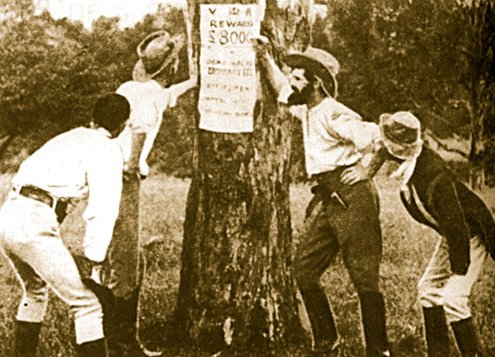

In [4]:
# image sourced from Wikidata.

if datum['image']:
    display(Image(datum['image'], width=300, height=300))

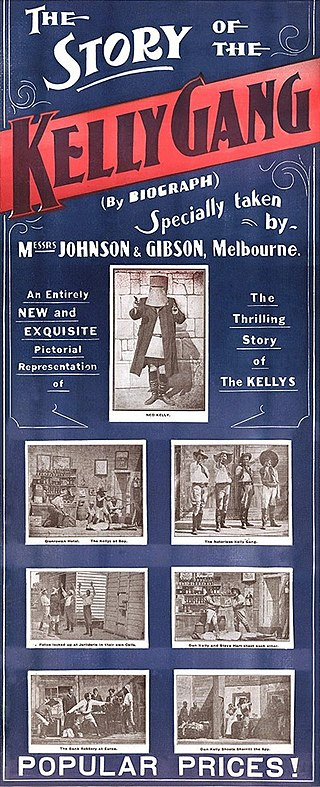

In [5]:
# image sourced from Wikipedia.

if datum['article']:
    wikipedia_query = requests.get(f"https://en.wikipedia.org/api/rest_v1/page/summary/{pathlib.Path(datum['article']).name}")
    wikipedia_query = json.loads(wikipedia_query.text)
    if pydash.get(wikipedia_query, 'thumbnail.source'):
        display(Image(pydash.get(wikipedia_query, 'thumbnail.source'), width=300, height=300))